## Data

`paris.dimacs` is a simple graph. Easier to deal with, no way to account for changes in lines for example.

Each line consists of a pair of stations that are next to each other in some line.

`stationsNoAccent.data` defines a directed graph as an union of paths, where each path is a valid direction of the metro. For a normal line, there are two paths, starting at each one of the two terminus. If a line splits (line 7, 13, etc) then the line itself will be a sum of paths.

## Imports

In [7]:
import networkx as nx
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import pandas as pd


# No transferts taken into account

In [9]:
G = nx.Graph()

with open("paris.dimacs", "r", encoding="ISO-8859-1") as f:
    #read and ignore the first line
    f.readline()
    for l in f:
        _, u, v = l.split()
        G.add_edge(u, v, weight=1)

In [10]:
#all pairs shortest path
path = nx.all_pairs_shortest_path(G)

In [11]:
#dictionary with the sum of the length of the paths
sum_path = {}
for key, value in path:
    sum_path[key] = sum([len(x) for x in value.values()]) / len(G.nodes())

In [12]:
#sort by increasing sum of the length of the paths
sum_path = collections.OrderedDict(sorted(sum_path.items(), key=lambda t: t[1]))

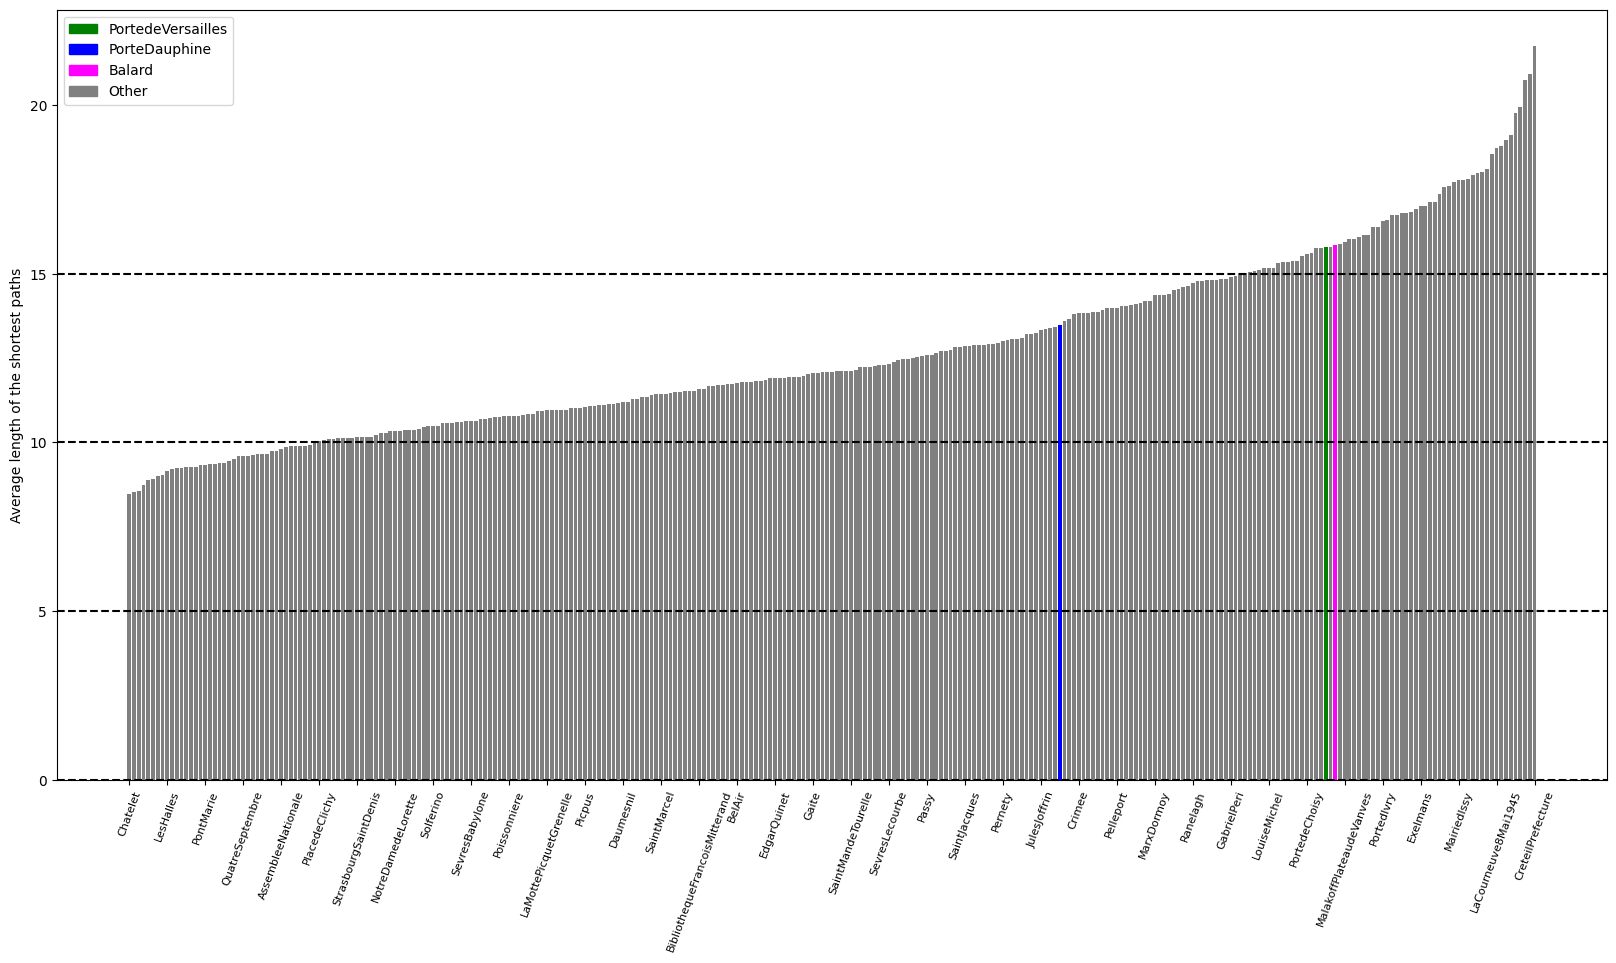

In [13]:
#plot the histogram
plt.figure(figsize=(20,10))
#plot in green if key is PortedeVersailles, in red if key is PorteDauphine, in blue otherwise
plt.bar(range(len(sum_path)), sum_path.values(), align='center', color=['g' if x == 'PortedeVersailles' else 'b' if x == 'PorteDauphine' else 'magenta' if x == "Balard" else 'gray' for x in sum_path.keys()])

keys = list(sum_path.keys())

#plot only one every other 10 labels on x axis, and rotate them, and write smaller labels
plt.xticks(range(0, len(keys), 8), keys[::8], rotation=70, fontsize=8)

#add some dashed horizontal lines to see where it arrives on y-axis
for i in range(0,20,5):
    plt.axhline(y=i, color='black', linestyle='--')

#add a legend
plt.legend(handles=[mpatches.Patch(color='green', label='PortedeVersailles'), mpatches.Patch(color='blue', label='PorteDauphine'), mpatches.Patch(color='magenta', label='Balard'), mpatches.Patch(color='gray', label='Other')])

#add y axis label
plt.ylabel("Average length of the shortest paths")

plt.show()

# Add transferts

In [109]:
# Define the cost of transfert
transfert_penalty = 100000000

## Very sub-optimal code

In [110]:
Gt = nx.Graph()
# Add line info to node name, to create one node per line in intersections


table = str.maketrans('', '', "' -")
with open("stationsNoAccent.data", "r", encoding= "iso-8859-1") as f:
    #read and ignore the first line
    for l in f:
        if l.startswith('##'):
            # Starting a new path
            last_station = None
        else:
            info, station = l.strip().split(':')
            line, segment = info.split('-')
            if last_station is not None:
                attr = {'line': line, 'segment': segment, 'weight':1.0}
                Gt.add_edge(f"{last_station}_{line}", f"{station}_{line}", **attr)
            last_station = station

In [111]:
# Now create links between intersection nodes
to_treat = [c for c, cnt in collections.Counter([n.split("_")[0] for n in Gt.nodes()]).items() if cnt > 1]

for station in to_treat:
    dups = itertools.filterfalse(lambda x: station != x.split("_")[0], Gt.nodes())
    for x, y in itertools.combinations(dups, 2):
        line = f"{x}_t_{y.split('_')[1]}"
        attr = {'line': line, 'segment': "transfer", 'weight':transfert_penalty}
        Gt.add_edge(x, y, **attr)


In [112]:
# Compare distances with the initial graph

pathG = dict(nx.all_pairs_bellman_ford_path_length(G, weight='weight'))
pathG_trajets = dict(nx.all_pairs_bellman_ford_path(G, weight='weight'))

pathGt = dict(nx.all_pairs_bellman_ford_path_length(Gt, weight='weight'))
pathGt_trajets = dict(nx.all_pairs_bellman_ford_path(Gt, weight='weight'))



In [113]:
# For Gt, we need to manually get back the shortest paths
table = str.maketrans('', '', "' -")
tuples = []
for source, vals in pathGt.items():
    for target, dist in vals.items():
        s = source.split('_')[0].translate(table)
        t = target.split('_')[0].translate(table)
        tuples.append((s, t, dist, pathGt_trajets[source][target]))
df = pd.DataFrame(tuples, columns = ['source', 'target', 'distance', 'trajet'])
df.sort_values(by=['source', 'target', 'distance'], inplace=True, axis = 0)
df.groupby(by=['source', 'target'], group_keys=False, as_index=True)
final = df.groupby(by=['source', 'target'], group_keys=False, as_index=False).agg(lambda s: s.tolist()[0])
pathGt_final = final.pivot(index='source', columns = 'target', values='distance').to_dict()
pathGt_final_trajets = final.pivot(index='source', columns = 'target', values='trajet').to_dict()

In [114]:
def num_transferts_complete_path(path):
    transferts = 0
    for i in range(len(path)-1):
        if path[i].split('_')[0] == path[i+1].split('_')[0]:
           transferts += 1
    return transferts

def num_transferts_simple_path(path):
    # Not working yet
    table = str.maketrans('', '', "' -")
    transferts = 0
    for i in range(1, len(path)-1):
        u, v = path[i-1], path[i+1]
        # Check if they belong to the same line looking at number in name
        U = set([n.split('_')[1] for n in Gt.nodes() if u in n.translate(table)])
        V = set([n.split('_')[1] for n in Gt.nodes() if v in n.translate(table)])
        if not U.intersection(V):
            transferts += 1
    return transferts

# Compare results

In [90]:
import re
# @title Shortest distance. { display-mode: "form" , run: "auto"}
a = 'Convention' # @param ['Abbesses', 'Alesia', 'AlexandreDumas', 'AlfortEcoleVeterinaire', 'AlmaMarceau', 'AnatoleFrance', 'Anvers', 'Argentine', 'ArtsetMetiers', 'AssembleeNationale', 'AubervilliersPantinQuatreChemins', 'AvenueEmileZola', 'Avron', 'Balard', 'BarbesRochechouart', 'Bastille', 'BelAir', 'Belleville', 'Berault', 'Bercy', 'BibliothequeFrancoisMitterand', 'Billancourt', 'BirHakeim', 'Blanche', 'BobignyPabloPicasso', 'BobignyPantinRaymondQueneau', 'Boissiere', 'Bolivar', 'BonneNouvelle', 'Botzaris', 'Boucicaut', 'BouletsMontreuil', 'BoulogneJeanJaures', 'BoulognePontdeSaintCloud', 'Bourse', 'BreguetSabin', 'Brochant', 'ButtesChaumont', 'Buzenval', 'Cadet', 'Cambronne', 'CampoFormio', 'CardinalLemoine', 'CarrefourPleyel', 'CensierDaubenton', 'ChampsElyseesClemenceau', 'ChardonLagache', 'CharentonEcoles', 'CharlesMichels', 'CharlesdeGaulleEtoile', 'Charonne', 'ChateauLandon', 'ChateauRouge', 'ChateaudEau', 'ChateaudeVincennes', 'Chatelet', 'ChatillonMontrouge', 'ChausseedAntinLaFayette', 'CheminVert', 'Chevaleret', 'Cite', 'ClunyLaSorbonne', 'ColonelFabien', 'Commerce', 'Concorde', 'Convention', 'CorentinCariou', 'CorentinCelton', 'Corvisart', 'CourSaintEmilion', 'Courcelles', 'Couronnes', 'CreteilLEchat', 'CreteilPrefecture', 'CreteilUniversite', 'Crimee', 'CroixdeChavaux', 'Danube', 'Daumesnil', 'DenfertRochereau', 'Dugommier', 'Dupleix', 'Duroc', 'EcoleMilitaire', 'EdgarQuinet', 'EglisedAuteuil', 'EglisedePantin', 'EsplanadedeLaDefense', 'EtienneMarcel', 'Europe', 'Exelmans', 'FaidherbeChaligny', 'Falguiere', 'FelixFaure', 'FillesduCalvaire', 'FortdAubervilliers', 'FranklinD.Roosevelt', 'GabrielPeri', 'Gaite', 'Gallieni', 'Gambetta', 'GaredAusterlitz', 'GaredeLyon', 'GaredelEst', 'GareduNord', 'Garibaldi', 'GeorgeV', 'Glaciere', 'Goncourt', 'GrandeArchedeLaDefense', 'GuyMoquet', 'HavreCaumartin', 'Hoche', 'HoteldeVille', 'Iena', 'Invalides', 'JacquesBonsergent', 'Jasmin', 'Jaures', 'Javel', 'Jourdain', 'JulesJoffrin', 'Jussieu', 'Kleber', 'LaChapelle', 'LaCourneuve8Mai1945', 'LaFourche', 'LaMottePicquetGrenelle', 'LaMuette', 'LamarckCaulaincourt', 'LatourMaubourg', 'Laumiere', 'LeKremlinBicetre', 'LePeletier', 'LedruRollin', 'LesGobelins', 'LesHalles', 'LesSablons', 'Liberte', 'Liege', 'LouisBlanc', 'LouiseMichel', 'Lourmel', 'LouvreRivoli', 'Mabillon', 'Madeleine', 'MairiedIssy', 'MairiedIvry', 'MairiedeClichy', 'MairiedeMontreuil', 'MairiedeMontrouge', 'MairiedeSaintOuen', 'MairiedesLilas', 'MaisonBlanche', 'MaisonsAlfortLesJuilliottes', 'MaisonsAlfortStade', 'MalakoffPlateaudeVanves', 'MalakoffRueEtienneDolet', 'Malesherbes', 'Maraichers', 'MarcadetPoissonniers', 'MarcelSembat', 'MarxDormoy', 'MaubertMutualite', 'Menilmontant', 'MichelAngeAuteuil', 'MichelAngeMolitor', 'MichelBizot', 'Mirabeau', 'Miromesnil', 'Monceau', 'Montgallet', 'MontparnasseBienvenüe', 'MoutonDuvernet', 'Nation', 'Nationale', 'NotreDamedeLorette', 'NotreDamedesChamps', 'Oberkampf', 'Odeon', 'Olympiades', 'Opera', 'Ourcq', 'PalaisRoyalMuseeduLouvre', 'Parmentier', 'Passy', 'Pasteur', 'Pelleport', 'PereLachaise', 'Pereire', 'Pernety', 'PhilippeAuguste', 'Picpus', 'PierreCurie', 'Pigalle', 'PlaceMonge', 'PlacedItalie', 'PlacedeClichy', 'PlacedesFetes', 'Plaisance', 'Poissonniere', 'PontMarie', 'PontNeuf', 'PontdeLevalloisBecon', 'PontdeNeuilly', 'PontdeSevres', 'PorteDauphine', 'PorteDoree', 'PorteMaillot', 'PortedAuteuil', 'PortedItalie', 'PortedIvry', 'PortedOrleans', 'PortedeBagnolet', 'PortedeChamperret', 'PortedeCharenton', 'PortedeChoisy', 'PortedeClichy', 'PortedeClignancourt', 'PortedeMontreuil', 'PortedePantin', 'PortedeSaintCloud', 'PortedeSaintOuen', 'PortedeVanves', 'PortedeVersailles', 'PortedeVincennes', 'PortedelaChapelle', 'PortedelaVillette', 'PortedesLilas', 'PreSaintGervais', 'Pyramides', 'Pyrenees', 'QuaidelaGare', 'QuaidelaRapee', 'QuatreSeptembre', 'Rambuteau', 'Ranelagh', 'Raspail', 'ReaumurSebastopol', 'Rennes', 'Republique', 'ReuillyDiderot', 'RichardLenoir', 'RichelieuDrouot', 'Riquet', 'Robespierre', 'Rome', 'RueMontmartre', 'RuedelaPompe', 'RueduBac', 'SaintAmbroise', 'SaintAugustin', 'SaintDenisBasilique', 'SaintDenisPortedeParis', 'SaintFargeau', 'SaintFrancoisXavier', 'SaintGeorges', 'SaintGermaindesPres', 'SaintJacques', 'SaintLazare', 'SaintMandeTourelle', 'SaintMarcel', 'SaintMaur', 'SaintMichel', 'SaintPaul', 'SaintPhilippeduRoule', 'SaintPlacide', 'SaintSebastienFroissart', 'SaintSulpice', 'Segur', 'Sentier', 'SevresBabylone', 'SevresLecourbe', 'Simplon', 'Solferino', 'Stalingrad', 'StrasbourgSaintDenis', 'SullyMorland', 'Telegraphe', 'Temple', 'Ternes', 'Tolbiac', 'Trinite', 'Trocadero', 'Tuileries', 'Vaneau', 'Varenne', 'Vaugirard', 'Vavin', 'VictorHugo', 'VillejuifLeoLagrange', 'VillejuifLouisAragon', 'VillejuifPaulVaillantCouturier', 'Villiers', 'Volontaires', 'Voltaire', 'Wagram']
b = 'PorteDauphine' # @param ['Abbesses', 'Alesia', 'AlexandreDumas', 'AlfortEcoleVeterinaire', 'AlmaMarceau', 'AnatoleFrance', 'Anvers', 'Argentine', 'ArtsetMetiers', 'AssembleeNationale', 'AubervilliersPantinQuatreChemins', 'AvenueEmileZola', 'Avron', 'Balard', 'BarbesRochechouart', 'Bastille', 'BelAir', 'Belleville', 'Berault', 'Bercy', 'BibliothequeFrancoisMitterand', 'Billancourt', 'BirHakeim', 'Blanche', 'BobignyPabloPicasso', 'BobignyPantinRaymondQueneau', 'Boissiere', 'Bolivar', 'BonneNouvelle', 'Botzaris', 'Boucicaut', 'BouletsMontreuil', 'BoulogneJeanJaures', 'BoulognePontdeSaintCloud', 'Bourse', 'BreguetSabin', 'Brochant', 'ButtesChaumont', 'Buzenval', 'Cadet', 'Cambronne', 'CampoFormio', 'CardinalLemoine', 'CarrefourPleyel', 'CensierDaubenton', 'ChampsElyseesClemenceau', 'ChardonLagache', 'CharentonEcoles', 'CharlesMichels', 'CharlesdeGaulleEtoile', 'Charonne', 'ChateauLandon', 'ChateauRouge', 'ChateaudEau', 'ChateaudeVincennes', 'Chatelet', 'ChatillonMontrouge', 'ChausseedAntinLaFayette', 'CheminVert', 'Chevaleret', 'Cite', 'ClunyLaSorbonne', 'ColonelFabien', 'Commerce', 'Concorde', 'Convention', 'CorentinCariou', 'CorentinCelton', 'Corvisart', 'CourSaintEmilion', 'Courcelles', 'Couronnes', 'CreteilLEchat', 'CreteilPrefecture', 'CreteilUniversite', 'Crimee', 'CroixdeChavaux', 'Danube', 'Daumesnil', 'DenfertRochereau', 'Dugommier', 'Dupleix', 'Duroc', 'EcoleMilitaire', 'EdgarQuinet', 'EglisedAuteuil', 'EglisedePantin', 'EsplanadedeLaDefense', 'EtienneMarcel', 'Europe', 'Exelmans', 'FaidherbeChaligny', 'Falguiere', 'FelixFaure', 'FillesduCalvaire', 'FortdAubervilliers', 'FranklinD.Roosevelt', 'GabrielPeri', 'Gaite', 'Gallieni', 'Gambetta', 'GaredAusterlitz', 'GaredeLyon', 'GaredelEst', 'GareduNord', 'Garibaldi', 'GeorgeV', 'Glaciere', 'Goncourt', 'GrandeArchedeLaDefense', 'GuyMoquet', 'HavreCaumartin', 'Hoche', 'HoteldeVille', 'Iena', 'Invalides', 'JacquesBonsergent', 'Jasmin', 'Jaures', 'Javel', 'Jourdain', 'JulesJoffrin', 'Jussieu', 'Kleber', 'LaChapelle', 'LaCourneuve8Mai1945', 'LaFourche', 'LaMottePicquetGrenelle', 'LaMuette', 'LamarckCaulaincourt', 'LatourMaubourg', 'Laumiere', 'LeKremlinBicetre', 'LePeletier', 'LedruRollin', 'LesGobelins', 'LesHalles', 'LesSablons', 'Liberte', 'Liege', 'LouisBlanc', 'LouiseMichel', 'Lourmel', 'LouvreRivoli', 'Mabillon', 'Madeleine', 'MairiedIssy', 'MairiedIvry', 'MairiedeClichy', 'MairiedeMontreuil', 'MairiedeMontrouge', 'MairiedeSaintOuen', 'MairiedesLilas', 'MaisonBlanche', 'MaisonsAlfortLesJuilliottes', 'MaisonsAlfortStade', 'MalakoffPlateaudeVanves', 'MalakoffRueEtienneDolet', 'Malesherbes', 'Maraichers', 'MarcadetPoissonniers', 'MarcelSembat', 'MarxDormoy', 'MaubertMutualite', 'Menilmontant', 'MichelAngeAuteuil', 'MichelAngeMolitor', 'MichelBizot', 'Mirabeau', 'Miromesnil', 'Monceau', 'Montgallet', 'MontparnasseBienvenüe', 'MoutonDuvernet', 'Nation', 'Nationale', 'NotreDamedeLorette', 'NotreDamedesChamps', 'Oberkampf', 'Odeon', 'Olympiades', 'Opera', 'Ourcq', 'PalaisRoyalMuseeduLouvre', 'Parmentier', 'Passy', 'Pasteur', 'Pelleport', 'PereLachaise', 'Pereire', 'Pernety', 'PhilippeAuguste', 'Picpus', 'PierreCurie', 'Pigalle', 'PlaceMonge', 'PlacedItalie', 'PlacedeClichy', 'PlacedesFetes', 'Plaisance', 'Poissonniere', 'PontMarie', 'PontNeuf', 'PontdeLevalloisBecon', 'PontdeNeuilly', 'PontdeSevres', 'PorteDauphine', 'PorteDoree', 'PorteMaillot', 'PortedAuteuil', 'PortedItalie', 'PortedIvry', 'PortedOrleans', 'PortedeBagnolet', 'PortedeChamperret', 'PortedeCharenton', 'PortedeChoisy', 'PortedeClichy', 'PortedeClignancourt', 'PortedeMontreuil', 'PortedePantin', 'PortedeSaintCloud', 'PortedeSaintOuen', 'PortedeVanves', 'PortedeVersailles', 'PortedeVincennes', 'PortedelaChapelle', 'PortedelaVillette', 'PortedesLilas', 'PreSaintGervais', 'Pyramides', 'Pyrenees', 'QuaidelaGare', 'QuaidelaRapee', 'QuatreSeptembre', 'Rambuteau', 'Ranelagh', 'Raspail', 'ReaumurSebastopol', 'Rennes', 'Republique', 'ReuillyDiderot', 'RichardLenoir', 'RichelieuDrouot', 'Riquet', 'Robespierre', 'Rome', 'RueMontmartre', 'RuedelaPompe', 'RueduBac', 'SaintAmbroise', 'SaintAugustin', 'SaintDenisBasilique', 'SaintDenisPortedeParis', 'SaintFargeau', 'SaintFrancoisXavier', 'SaintGeorges', 'SaintGermaindesPres', 'SaintJacques', 'SaintLazare', 'SaintMandeTourelle', 'SaintMarcel', 'SaintMaur', 'SaintMichel', 'SaintPaul', 'SaintPhilippeduRoule', 'SaintPlacide', 'SaintSebastienFroissart', 'SaintSulpice', 'Segur', 'Sentier', 'SevresBabylone', 'SevresLecourbe', 'Simplon', 'Solferino', 'Stalingrad', 'StrasbourgSaintDenis', 'SullyMorland', 'Telegraphe', 'Temple', 'Ternes', 'Tolbiac', 'Trinite', 'Trocadero', 'Tuileries', 'Vaneau', 'Varenne', 'Vaugirard', 'Vavin', 'VictorHugo', 'VillejuifLeoLagrange', 'VillejuifLouisAragon', 'VillejuifPaulVaillantCouturier', 'Villiers', 'Volontaires', 'Voltaire', 'Wagram']

path_simple = pathG_trajets[a][b]
path_complete = pathGt_final_trajets[a][b]

transferts_simple = num_transferts_simple_path(path_simple)
transferts_complet = num_transferts_complete_path(path_complete)


print(f"Simple Distance from '{a}' to  '{b}': {pathG[a][b] + transferts_simple*transfert_penalty} -- (connections (approx): {transferts_simple})")
for s in pathG_trajets[a][b]:
    print("\t", s)


print()
print()

print(f"Transfer Distance from '{a}' to  '{b}': {round(pathGt_final[a][b],2)} -- (connections (exact): {transferts_complet})")
aux = list(pathGt_final_trajets[a][b])
table = str.maketrans('', '', "' -")
if not a in aux[0].translate(table):
    aux = reversed(aux)
for s in aux:
    print("\t", s)


Sikora Distance from 'Convention' to  'PorteDauphine': 3014 -- (connections (approx): 3)
	 Convention
	 Vaugirard
	 Volontaires
	 Pasteur
	 MontparnasseBienvenüe
	 Duroc
	 SaintFrancoisXavier
	 Varenne
	 Invalides
	 ChampsElyseesClemenceau
	 FranklinD.Roosevelt
	 GeorgeV
	 CharlesdeGaulleEtoile
	 VictorHugo
	 PorteDauphine


Transfer Distance from 'Convention' to  'PorteDauphine': 1028.0 -- (connections (exact): 1)
	 Convention_12
	 Vaugirard_12
	 Volontaires_12
	 Pasteur_12
	 Falguiere_12
	 Montparnasse - Bienvenüe_12
	 Notre-Dame des Champs_12
	 Rennes_12
	 Sevres - Babylone_12
	 Rue du Bac_12
	 Solferino_12
	 Assemblee Nationale_12
	 Concorde_12
	 Madeleine_12
	 Saint-Lazare_12
	 Trinite_12
	 Notre-Dame de Lorette_12
	 Saint-Georges_12
	 Pigalle_12
	 Pigalle_2
	 Blanche_2
	 Place de Clichy_2
	 Rome_2
	 Villiers_2
	 Monceau_2
	 Courcelles_2
	 Ternes_2
	 Charles de Gaulle - Etoile_2
	 Victor Hugo_2
	 Porte Dauphine_2


## Plot

In [106]:
# Colors
colors = {
    'PortedeVersailles': 'green',
    'PorteDauphine': 'blue',
    'Balard': 'magenta',
    'Plaisance': 'cyan',
    'ReuillyDiderot': 'yellow'
}

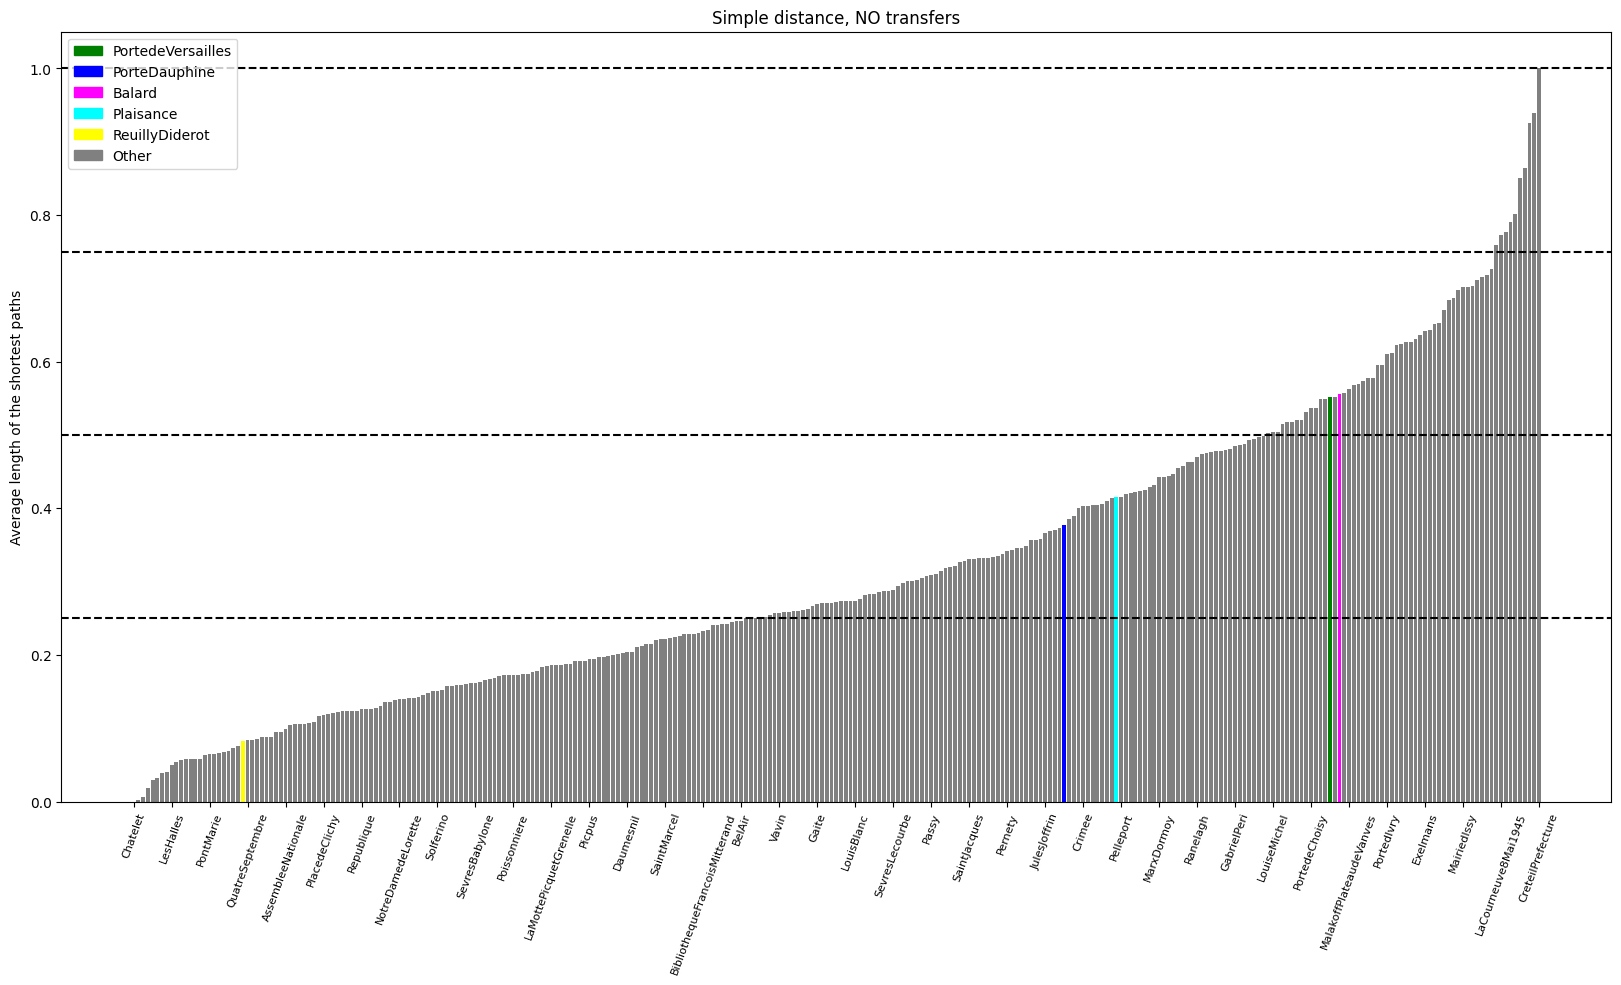

In [107]:
df = pd.DataFrame(pathG).sum(axis=1).sort_values()
df = (df-df.min()) / (df.max()-df.min())
#plot the histogram
plt.figure(figsize=(20,10))

#plot in green if key is PortedeVersailles, in red if key is PorteDauphine, in blue otherwise
clist = [colors.get(x, 'gray') for x in df.index]
plt.bar(range(len(df)), df.values, align='center', color=clist)

keys = list(df.index)

#plot only one every other 10 labels on x axis, and rotate them, and write smaller labels
plt.xticks(range(0, len(keys), 8), keys[::8], rotation=70, fontsize=8)

#add some dashed horizontal lines to see where it arrives on y-axis
for i in range(1,5):
    plt.axhline(y=i/4, color='black', linestyle='--')

#add a legend
plt.legend(handles=[mpatches.Patch(color=value, label=key) for key, value in colors.items()] + [mpatches.Patch(color='gray', label='Other')])

#add y axis label
plt.ylabel("Average length of the shortest paths")

plt.title("Simple distance, NO transfers")
plt.show()

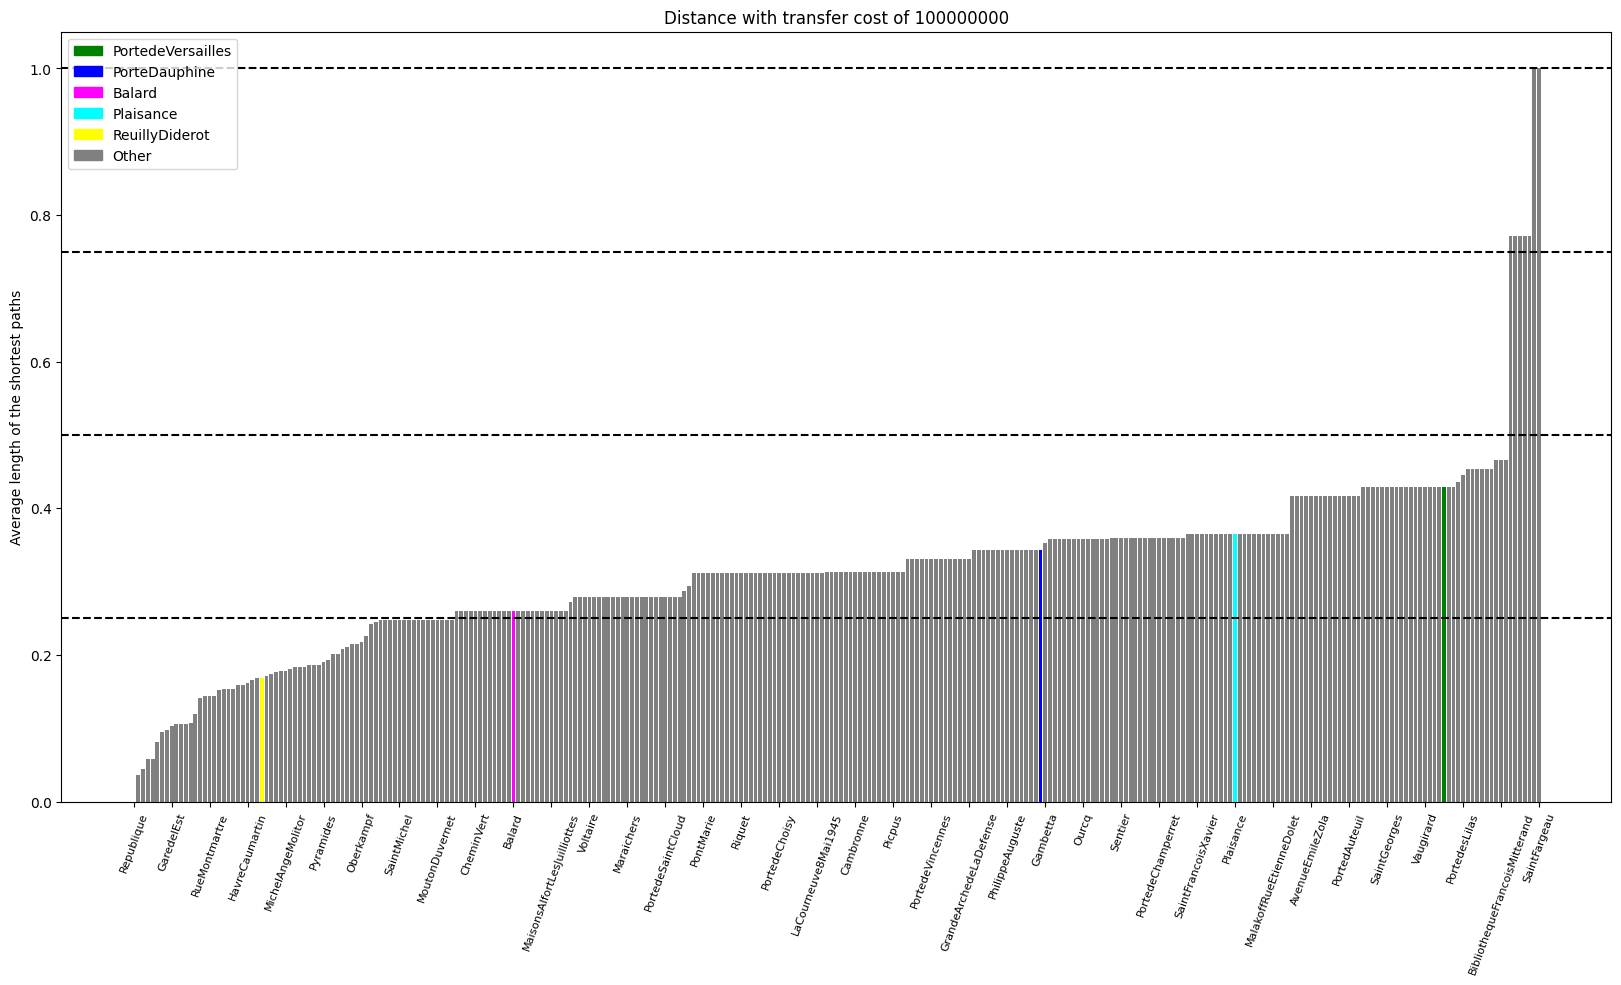

In [115]:
df = pd.DataFrame(pathGt_final).sum(axis=1).sort_values()
df = (df-df.min()) / (df.max()-df.min())
#plot the histogram
plt.figure(figsize=(20,10))


#plot in green if key is PortedeVersailles, in red if key is PorteDauphine, in blue otherwise
clist = [colors.get(x, 'gray') for x in df.index]
plt.bar(range(len(df)), df.values, align='center', color=clist)

keys = list(df.index)

#plot only one every other 10 labels on x axis, and rotate them, and write smaller labels
plt.xticks(range(0, len(keys), 8), keys[::8], rotation=70, fontsize=8)

#add some dashed horizontal lines to see where it arrives on y-axis
for i in range(1,5):
    plt.axhline(y=i/4, color='black', linestyle='--')

#add a legend
plt.legend(handles=[mpatches.Patch(color=value, label=key) for key, value in colors.items()] + [mpatches.Patch(color='gray', label='Other')])

#add y axis label
plt.ylabel("Average length of the shortest paths")

plt.title(f"Distance with transfer cost of {transfert_penalty}")
plt.show()